In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
SAMPLETHRESH = 50

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [4]:
stats = open_dataset('binned_stats.nc')
data  = open_dataset('pr_bl_terms.nc')

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx
    
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

In [6]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binmeanpr    = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_pdf(monthstats,bintype='1D',precipitating=True)
        predpr   = np.nansum(blpdf*binmeanpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0])
    realprdiffs.append(realprlist[1]-realprlist[0]) 

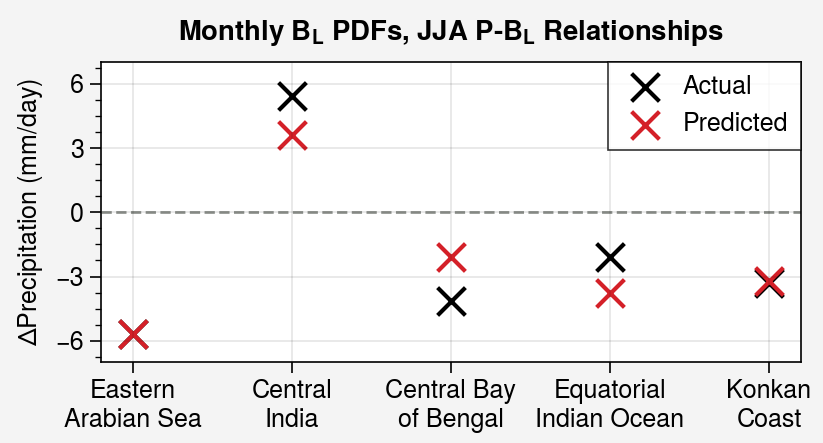

In [24]:
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(
         suptitle='Monthly $B_L$ PDFs, JJA P-$B_L$ Relationships',
          ylabel='$\Delta$Precipitation (mm/day)',ylim=(-7,7),yticks=3)
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,np.asarray(realprdiffs),color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,np.asarray(predprdiffs),color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_4.png',dpi=600)

In [23]:
for region,predprdiff,realprdiff in zip(REGIONS.keys(),predprdiffs,realprdiffs):
    percenterror = ((predprdiff-realprdiff)/realprdiff)*100
    print(f'{region}: {percenterror:.1f}%')

Eastern Arabian Sea: -0.2%
Central India: -33.5%
Central Bay of Bengal: -49.5%
Equatorial Indian Ocean: 80.6%
Konkan Coast: -2.1%


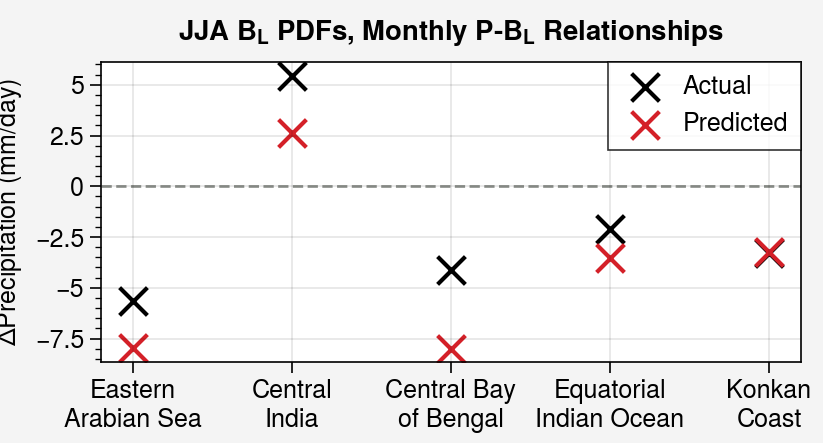

In [14]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    blpdf    = get_bl_pdf(regionstats.sum(dim='month'),precipitating=True)
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        binmeanpr  = get_bin_mean_pr(monthstats,bintype='1D')
        predpr   = np.nansum(blpdf*binmeanpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0]) 
    realprdiffs.append(realprlist[1]-realprlist[0])

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='JJA $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

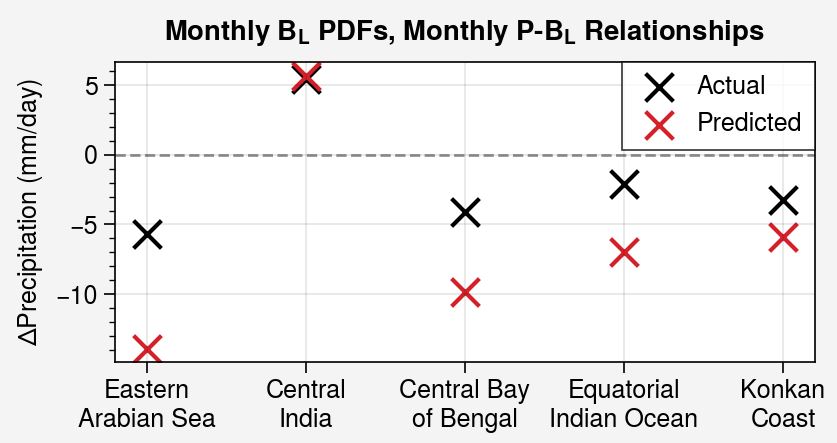

In [16]:
predprdiffs = []
realprdiffs = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    predprlist = []
    realprlist = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_bl_pdf(monthstats,precipitating=True)
        binmeanpr = get_bin_mean_pr(monthstats)
        predpr   = np.nansum(blpdf*binmeanpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
    predprdiffs.append(predprlist[1]-predprlist[0]) 
    realprdiffs.append(realprlist[1]-realprlist[0])

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr = np.asarray(realprdiffs)
predpr = np.asarray(predprdiffs)

fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

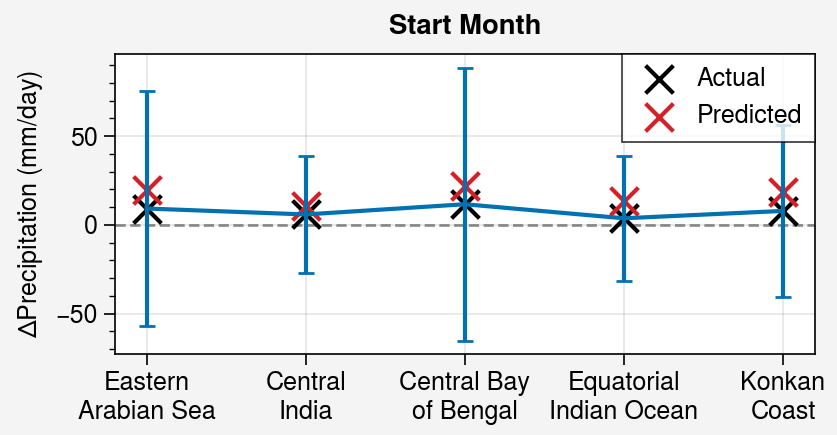

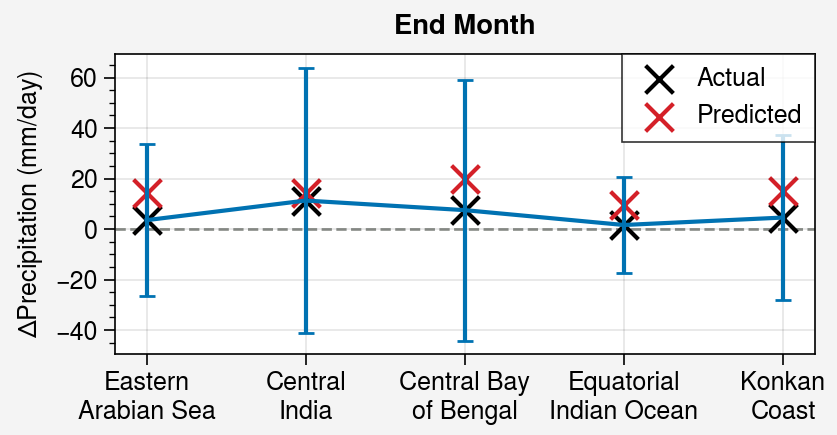

In [18]:
predprdiffs = []
realprdiffs = []
stdprdiffs  = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binmeanpr   = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
    predprlist = []
    realprlist = []
    stdprlist  = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_bl_pdf(monthstats,precipitating=True)
        predpr   = np.nansum(blpdf*binmeanpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        stdpr    = monthdata.pr.std(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
        stdprlist.append(stdpr)
    predprdiffs.append(predprlist[0]) 
    realprdiffs.append(realprlist[0]) 
    stdprdiffs.append(stdprlist[0])   
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr  = np.asarray(realprdiffs)
predpr  = np.asarray(predprdiffs)
stdpr   = np.asarray(stdprdiffs)
fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Start Month',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.errorbar(regions,realpr,yerr=(realpr+stdpr))
ax.legend(loc='ur',ncols=1)
pplt.show()


predprdiffs = []
realprdiffs = []
stdprdiffs  = []
for i,region in enumerate(REGIONS):
    regionstats = stats.sel(region=region)
    regiondata  = get_region(data,region)
    binmeanpr   = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
    predprlist = []
    realprlist = []
    stdprlist  = []
    months     = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = regionstats.sel(month=month)
        monthdata  = get_month(regiondata,month)
        blpdf    = get_bl_pdf(monthstats,precipitating=True)
        predpr   = np.nansum(blpdf*binmeanpr)
        realpr   = monthdata.pr.mean(dim=['lat','lon','time']).values
        stdpr    = monthdata.pr.std(dim=['lat','lon','time']).values
        predprlist.append(predpr)
        realprlist.append(realpr)
        stdprlist.append(stdpr)
    predprdiffs.append(predprlist[1]) 
    realprdiffs.append(realprlist[1]) 
    stdprdiffs.append(stdprlist[1]) 
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
realpr  = np.asarray(realprdiffs)
predpr  = np.asarray(predprdiffs)
stdpr   = np.asarray(stdprdiffs)
fig,ax = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='End Month',ylabel='$\Delta$Precipitation (mm/day)')
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.errorbar(regions,realpr,yerr=(realpr+stdpr))
ax.legend(loc='ur',ncols=1)
pplt.show()